# Mean-Variance Portfolio Theory

Constructing a Mean-Standard Deviation Diagram in order to visualize the Efficient Frontier through two methods:

1. Using brute force to generate many random portfolios, and
2. Using quadratic programming to work out a mathematical solution to the Markowitz Problem.

Following the guidance of this [article](https://medium.com/python-data/effient-frontier-in-python-34b0c3043314) as well as this [blog post](https://blog.quantopian.com/markowitz-portfolio-optimization-2/).

## Part 1: Obtaining Data

In [1]:
%load_ext dotenv
%dotenv
import os
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#  Apple / Amazon / Facebook / Google / Microsoft / Kors / Macy's / Ralph Lauren
stocks = ["AAPL", "AMZN", "FB", "GOOGL", "MSFT", "KORS", "M", "RL"]

quandl.ApiConfig.api_key = os.environ.get("API_TOKEN")
stock_data = quandl.get_table(
    "WIKI/PRICES",
    ticker=stocks,
    qopts={"columns": ["date", "ticker", "adj_close"]},
    date={"gte": "2014-1-1", "lte": "2015-12-31"}
)

daily_returns = stock_data.set_index("date").pivot(columns="ticker").pct_change()[1:]
daily_returns.head()

adj_close                                                    \
ticker          AAPL      AMZN        FB     GOOGL      KORS         M   
date                                                                     
2014-01-03 -0.021966 -0.003845 -0.002797 -0.007295  0.001213  0.002810   
2014-01-06  0.005453 -0.007088  0.048445  0.011149 -0.005696 -0.007284   
2014-01-07 -0.007156  0.011178  0.012587  0.019278 -0.037786 -0.018250   
2014-01-08  0.006338  0.009773  0.005352  0.002081 -0.013048 -0.006516   
2014-01-09 -0.012772 -0.002264 -0.017345 -0.009630  0.008728  0.076389   

                                
ticker          MSFT        RL  
date                            
2014-01-03 -0.006728  0.010378  
2014-01-06 -0.021132 -0.014166  
2014-01-07  0.007750  0.004122  
2014-01-08 -0.017852 -0.017560  
2014-01-09 -0.006432  0.003250

In [3]:
annual_returns = daily_returns.mean() * 240
variances = daily_returns.var() * 240
covariance_matrix = daily_returns.cov() * 240

## Part 2: Brute Force Random Generation

In [4]:
portfolio_returns = []
portfolio_standard_deviations = []

for _ in range(10000):
    # Randomize weights
    w = np.random.random(len(stocks))
    weights = w / sum(w)
    # Alternatively, randomize weights using the Dirichlet distribution
    # weights = np.random.dirichlet(np.ones(len(stocks)))
    
    # Get return of portfolio
    p_return = np.dot(weights, annual_returns)
    portfolio_returns.append(p_return)
    
    # Get standard deviation of portfolio
    p_variance = np.dot(np.dot(weights.T, covariance_matrix), weights)
    p_standard_deviation = np.sqrt(p_variance)
    portfolio_standard_deviations.append(p_standard_deviation)

portfolios = pd.DataFrame({
    "Standard Deviation": portfolio_standard_deviations,
    "Return": portfolio_returns
})
portfolios.head()

,Standard Deviation,Return
0,0.173274,0.054133
1,0.184314,-0.005344
2,0.179082,0.096125
3,0.169086,0.030075
4,0.181967,0.145718


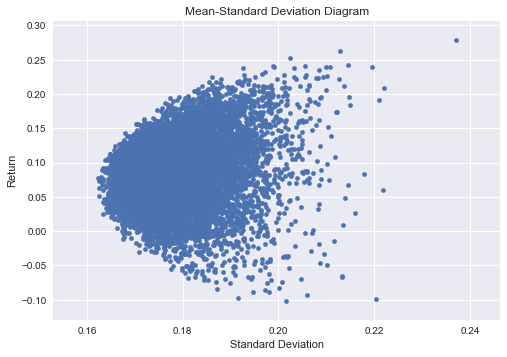

In [5]:
plt.style.use("seaborn")
portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviation",
    y="Return"
)

## Part 3: Modelling the Markowitz Problem

In [6]:
import cvxopt as opt

In [7]:
# Turn off progress printing 
opt.solvers.options['show_progress'] = False

# Set quadratic variables
n = len(stocks)
N = 100
mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
S = opt.matrix(np.array(covariance_matrix))
pbar = opt.matrix(annual_returns)

# Create constraint matrices
G = -opt.matrix(np.identity(n))
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

# Calculate efficient frontier weights using quadratic programming
optimal_weights = [opt.solvers.qp(mu*S, -pbar, G, h, A, b)["x"] for mu in mus]

# Calculate standard deviations and returns for frontier
optimal_standard_deviations = [np.sqrt(opt.blas.dot(x, S*x)) for x in optimal_weights]
optimal_returns = [opt.blas.dot(pbar, x) for x in optimal_weights]

# Construct optimal portfolios dataframe
optimal_portfolios = pd.DataFrame({
    "Standard Deviation": optimal_standard_deviations,
    "Return": optimal_returns
})

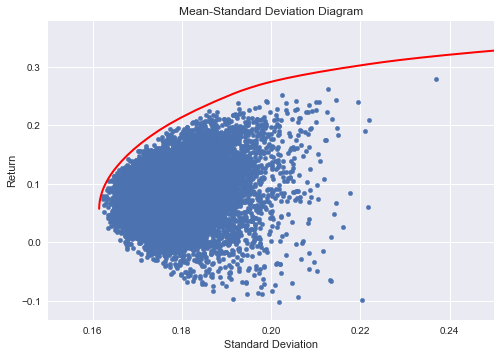

In [8]:
ax = portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviation",
    y="Return"
)
optimal_portfolios.plot.line(
    x="Standard Deviation",
    y="Return",
    color="red",
    linewidth=2,
    legend=False,
    xlim=(0.15, 0.25),
    ax=ax
)

## Part 4: Finding the Minimum Variance and Highest Sharpe Ratio Portfolios

In [9]:
optimal_portfolios.sort_values(by=["Standard Deviation"], ascending=True).head()

,Standard Deviation,Return
99,0.161474,0.056962
98,0.161474,0.057018
97,0.161474,0.057081
96,0.161474,0.057151
95,0.161474,0.057230


In [10]:
min_variance_index = optimal_portfolios.idxmin()["Standard Deviation"]
min_variance = optimal_portfolios.loc[min_variance_index]

min_variance_portfolio = pd.DataFrame({
    "Standard Deviation": [min_variance["Standard Deviation"]],
    "Return": [min_variance["Return"]]
})

In [11]:
risk_free_rate = 0.023  # US Treasury bond 12-month yield

optimal_portfolios["Sharpe Ratio"] = (optimal_portfolios["Return"] - risk_free_rate) / optimal_portfolios["Standard Deviation"]

optimal_portfolios.sort_values(by=["Sharpe Ratio"], ascending=False).head()

,Standard Deviation,Return,Sharpe Ratio
36,0.210828,0.291135,1.271819
35,0.215696,0.297309,1.271738
37,0.206879,0.285632,1.269496
34,0.221673,0.304237,1.268700
33,0.225239,0.308033,1.265467


In [12]:
max_sharpe_index = optimal_portfolios.idxmax()["Sharpe Ratio"]
max_sharpe = optimal_portfolios.loc[max_sharpe_index]

max_sharpe_portfolio = pd.DataFrame({
    "Standard Deviation": [max_sharpe["Standard Deviation"]],
    "Return": [max_sharpe["Return"]]
})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119ed2a90>],
      dtype=object)

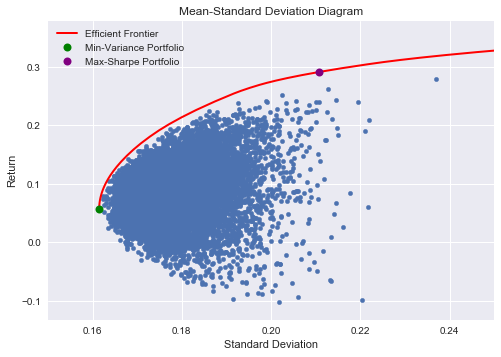

In [13]:
ax = portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviation",
    y="Return"
)
optimal_portfolios.plot.line(
    label="Efficient Frontier",
    x="Standard Deviation",
    y="Return",
    color="red",
    linewidth=2,
    ax=ax
)
min_variance_portfolio.plot(
    label="Min-Variance Portfolio",
    x="Standard Deviation",
    y="Return",
    color="green",
    marker="o",
    markersize=8,
    linestyle="none",
    subplots=True,
    ax=ax
)
max_sharpe_portfolio.plot(
    label="Max-Sharpe Portfolio",
    x="Standard Deviation",
    y="Return",
    color="purple",
    marker="o",
    markersize=8,
    linestyle="none",
    xlim=(0.15, 0.25),
    subplots=True,
    ax=ax
)

## Part 5: Evaluating the Portfolios

In [14]:
min_variance_weights = np.array(optimal_weights[min_variance_index])
max_sharpe_weights = np.array(optimal_weights[max_sharpe_index])
equal_weights = np.full(len(stocks), 1 / len(stocks))

new_stock_data = quandl.get_table(
    "WIKI/PRICES",
    ticker=stocks,
    qopts={"columns": ["date", "ticker", "adj_close"]},
    date={"gte": "2016-1-1", "lte": "2017-12-31"}
)

new_daily_returns = new_stock_data.set_index("date").pivot(columns="ticker").pct_change()[1:]

min_variance_portfolio_returns = new_daily_returns.dot(min_variance_weights).squeeze() + 1
max_sharpe_portfolio_returns = new_daily_returns.dot(max_sharpe_weights).squeeze() + 1
equally_weighted_portfolio_returns = new_daily_returns.dot(equal_weights) + 1

initial_investment = 10000
min_variance_portfolio_value = min_variance_portfolio_returns.cumprod() * initial_investment
max_sharpe_portfolio_value = max_sharpe_portfolio_returns.cumprod() * initial_investment
equally_weighted_portfolio_value = equally_weighted_portfolio_returns.cumprod() * initial_investment

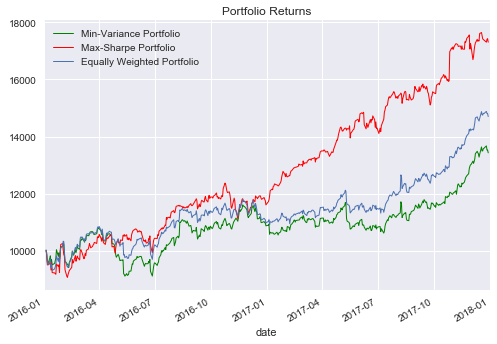

In [15]:
ax = min_variance_portfolio_value.plot.line(
    label="Min-Variance Portfolio",
    title="Portfolio Returns",
    color="green",
    linewidth=1,
    legend=True
)
max_sharpe_portfolio_value.plot.line(
    label="Max-Sharpe Portfolio",
    color="red",
    linewidth=1,
    legend=True,
    ax=ax
)
equally_weighted_portfolio_value.plot.line(
    label="Equally Weighted Portfolio",
    linewidth=1,
    legend=True,
    xlim=(pd.Timestamp(2016, 1, 1), pd.Timestamp(2018, 1, 1)),
    ax=ax
)